Data Cleaning
====

Illustrate + provide some basic stats on the data cleaning

In [1]:
import os

%load_ext autoreload
%autoreload 2

img_dir = "outputs/imgs/clean/"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [2]:
"""
Read the meal entries and provide some stats

"""
from analysis_utils import read

raw_entries = read.all_meal_info()

print(f"{len(raw_entries.p_id.unique())} unique participants; {len(raw_entries)} total entries")

/home/mh19137/seaco_smartwatch_paper/analysis_utils/clean.py:156: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copy.loc[start_time, col_name] = "Normal"
/home/mh19137/seaco_smartwatch_paper/analysis_utils/clean.py:227: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

100%|██████████| 83/83 [00:00<00:00, 982.21it/s]


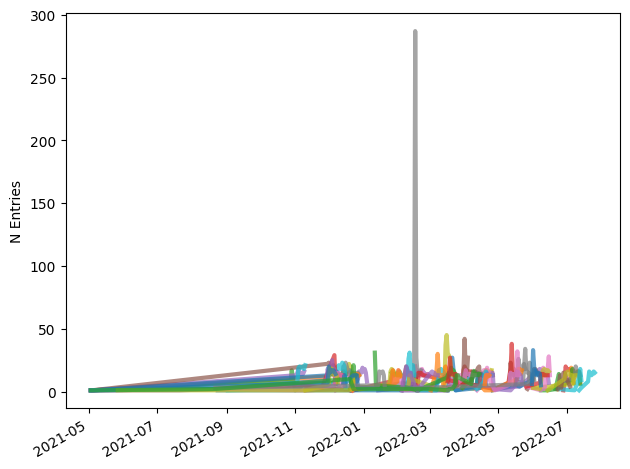

In [3]:
"""
Plot the number of entries per participant and the date

"""

import matplotlib.pyplot as plt

from tqdm import tqdm

def plot(df, path):
    fig, axis = plt.subplots()

    # Plot the number of entries per participant per day
    for _, group in tqdm(df.groupby("p_id")):
        # Find the number of entries per day
        dates = []
        n = []

        # Group by date
        group["Date"] = group.index.date
        for _, group2 in group.groupby("Date"):
            dates.append(group2.index[0].date())
            n.append(len(group2))

        axis.plot(dates, n, linewidth=3, alpha=0.7, linestyle="-")

    fig.autofmt_xdate()

    axis.set_ylabel("N Entries")
    fig.tight_layout()
    fig.savefig(path)

plot(raw_entries, f"{img_dir}/raw_entries_per_day.png")

100%|██████████| 83/83 [00:00<00:00, 1062.42it/s]


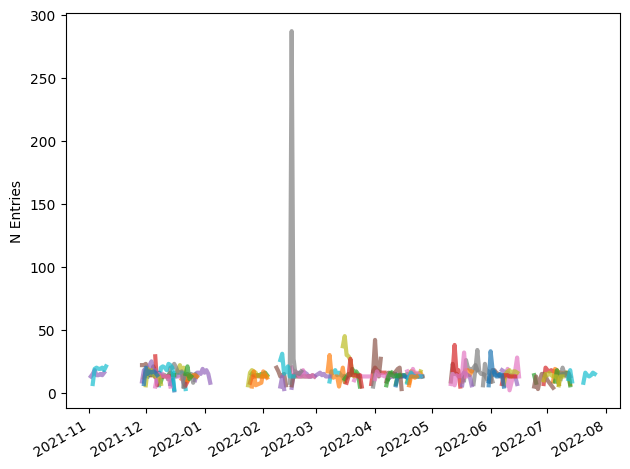

In [4]:
"""
Remove entries before the first day

"""
cleaned = raw_entries.copy()
cleaned = cleaned[cleaned["delta"].dt.days >= 0]

plot(cleaned, f"{img_dir}/removed_early_entries_per_day.png")


100%|██████████| 83/83 [00:00<00:00, 1047.61it/s]


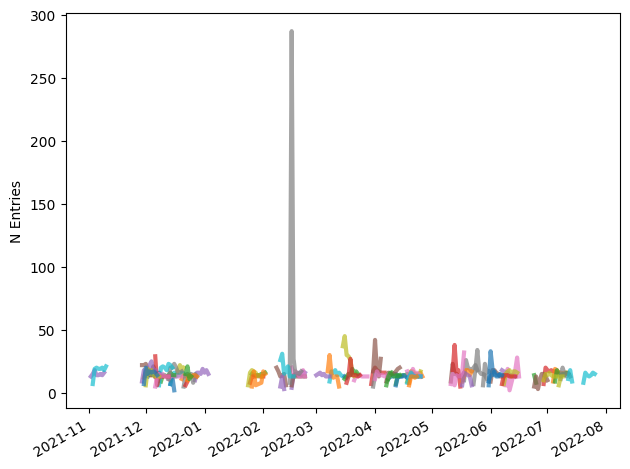

In [5]:
"""
Remove entries after day 7

"""
cleaned = cleaned[cleaned["delta"].dt.days <= 7]

plot(cleaned, f"{img_dir}/removed_late_early_entries_per_day.png")

100%|██████████| 83/83 [00:00<00:00, 1144.22it/s]


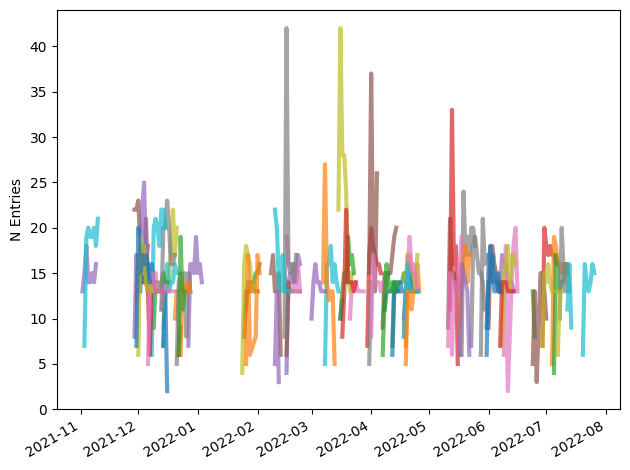

In [6]:
"""
Remove duplicates

"""
from analysis_utils import clean

cleaned = cleaned.sort_index()
cleaned = cleaned[~clean.duplicates(cleaned)]

plot(cleaned, f"{img_dir}/removed_duplicates_per_day.png")

100%|██████████| 82/82 [00:00<00:00, 1046.61it/s]


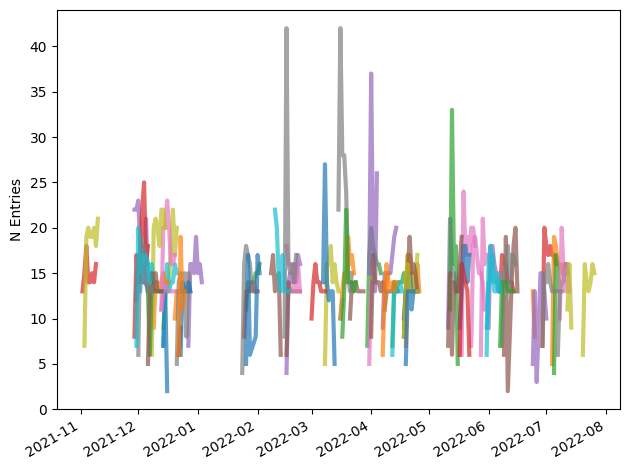

In [7]:
"""
Compare to the library function for cleaning

"""
cleaned2 = clean.cleaned_smartwatch(keep_catchups=True, keep_day0=True)

plot(cleaned2, f"{img_dir}/removed_duplicates_per_day_lib.png")

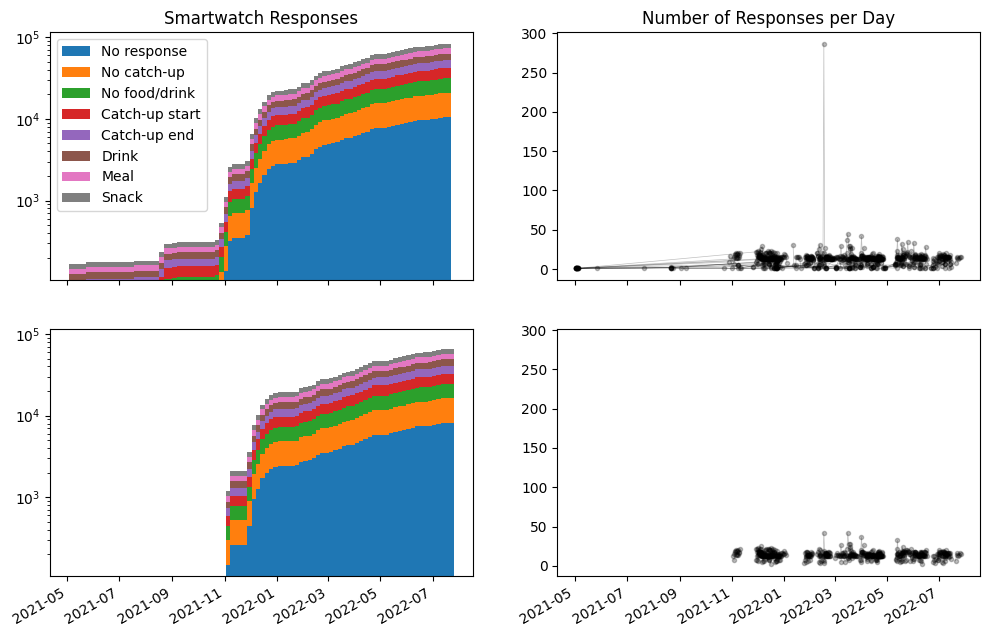

In [8]:
"""
Make a summary plot

"""

import pandas as pd
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].sharex(axes[1, 0])
axes[0, 0].sharey(axes[1, 0])
axes[0, 0].set_yscale("log")

axes[0, 1].sharex(axes[1, 1])
axes[0, 1].sharey(axes[1, 1])


# Plot the cumulative entries
def cumulative(axis: plt.Axes, df: pd.DataFrame) -> None:
    # Sort the meal type labels
    min_time, max_time = df.index.min(), df.index.max()
    bins = pd.date_range(min_time, max_time, freq="5D")

    labels = df["meal_type"].unique()
    labels = [
        *[l for l in labels if l.startswith("No ")],
        *[l for l in labels if l.startswith("Catch-up")],
        *labels,
    ]  # Put them in the desired order
    labels = list(dict.fromkeys(labels))  # Remove duplicates, preserve order

    data = [(df["meal_type"] == meal_type).index for meal_type in labels]

    axis.hist(data, stacked=True, bins=bins, label=labels, cumulative=True)


def find_n_entries(
    meal_info: pd.DataFrame,
) -> dict[int, tuple[pd.Series, list]]:
    # build up a dictionary of the number of entries per day per participant
    participant_entries = {}

    # Iterate over participants
    for participant in meal_info["p_id"].unique():
        # For each participant, find how many entries there were on each day of the study
        df_slice = meal_info[meal_info["p_id"] == participant]

        # Get the start date
        dates = np.unique(df_slice.index.date)

        # Iterate over the participation days, finding how many entries were on each day
        entries_per_day = [np.sum(df_slice.index.date == date) for date in dates]

        participant_entries[participant] = (dates, entries_per_day)

    return participant_entries


def participant_entries_per_day(
    axis: plt.Axes,
    df: pd.DataFrame,
) -> None:
    # Get the dates and number of entries for each participant
    participant_entries = find_n_entries(df)

    plot_kw = {"color": "k", "alpha": 0.25, "marker": ".", "linewidth": 0.5}
    for dates, entries in participant_entries.values():
        axis.plot(dates, entries, **plot_kw)


cumulative(axes[0, 0], raw_entries)
cumulative(axes[1, 0], cleaned)

participant_entries_per_day(axes[0, 1], raw_entries)
participant_entries_per_day(axes[1, 1], cleaned)

# Plot the other thing
axes[0, 0].legend()

axes[0, 0].set_title("Smartwatch Responses")
axes[0, 1].set_title("Number of Responses per Day")
fig.autofmt_xdate()

fig.savefig(f"{img_dir}/cleaning_summary.png")

There is actually a small difference between these plots, but hopefully it doesn't matter...

/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


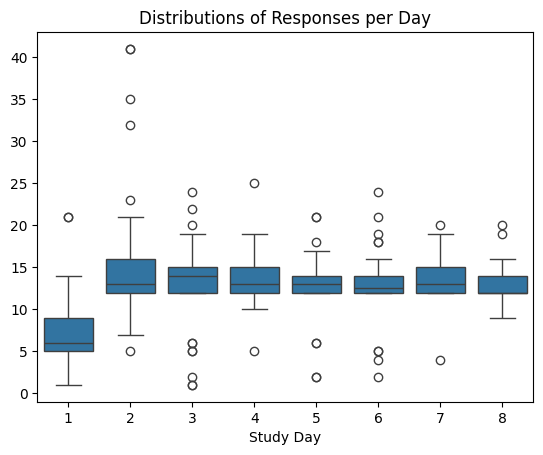

In [13]:
"""
Number of entries per day

"""

import seaborn as sns

entries = clean.cleaned_smartwatch(keep_catchups=False, keep_day0=True)
entries["day"] = entries["delta"].dt.days

entries_per_day = entries.groupby(["p_id", "day"]).size().reset_index(name="count")

fig, axis = plt.subplots()
sns.boxplot(x="day", y="count", data=entries_per_day, ax=axis)
axis.set_ylabel("Number of Entries")

axis.set_xlabel("Study Day")
axis.set_title("Distributions of Responses per Day")
axis.set_ylabel("")

axis.set_xticks(range(8), range(1, 9))

fig.savefig(f"{img_dir}/entries_per_day.png")

In [10]:
"""
Look at how many catchups there are

"""
from analysis_utils import clean
df = clean.cleaned_smartwatch(keep_catchups=True, keep_day0=True)

df["catchup_category"].value_counts(dropna=False)


catchup_category
NaN           8101
Normal          66
Open-ended      24
Late             8
Early            1
Long             1
Name: count, dtype: int64